In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

plt.rcParams["figure.figsize"] = (30, 10)
plt.rcParams["font.size"] = 18


In [94]:
steam_df = pd.read_csv("Data/steam/games-features-edit.csv")

print(steam_df['RecommendationCount'])


0        68991
1         2439
2         2319
3          888
4         2934
         ...  
12619        0
12620        0
12621        0
12622        0
12623        0
Name: RecommendationCount, Length: 12624, dtype: int64


1822


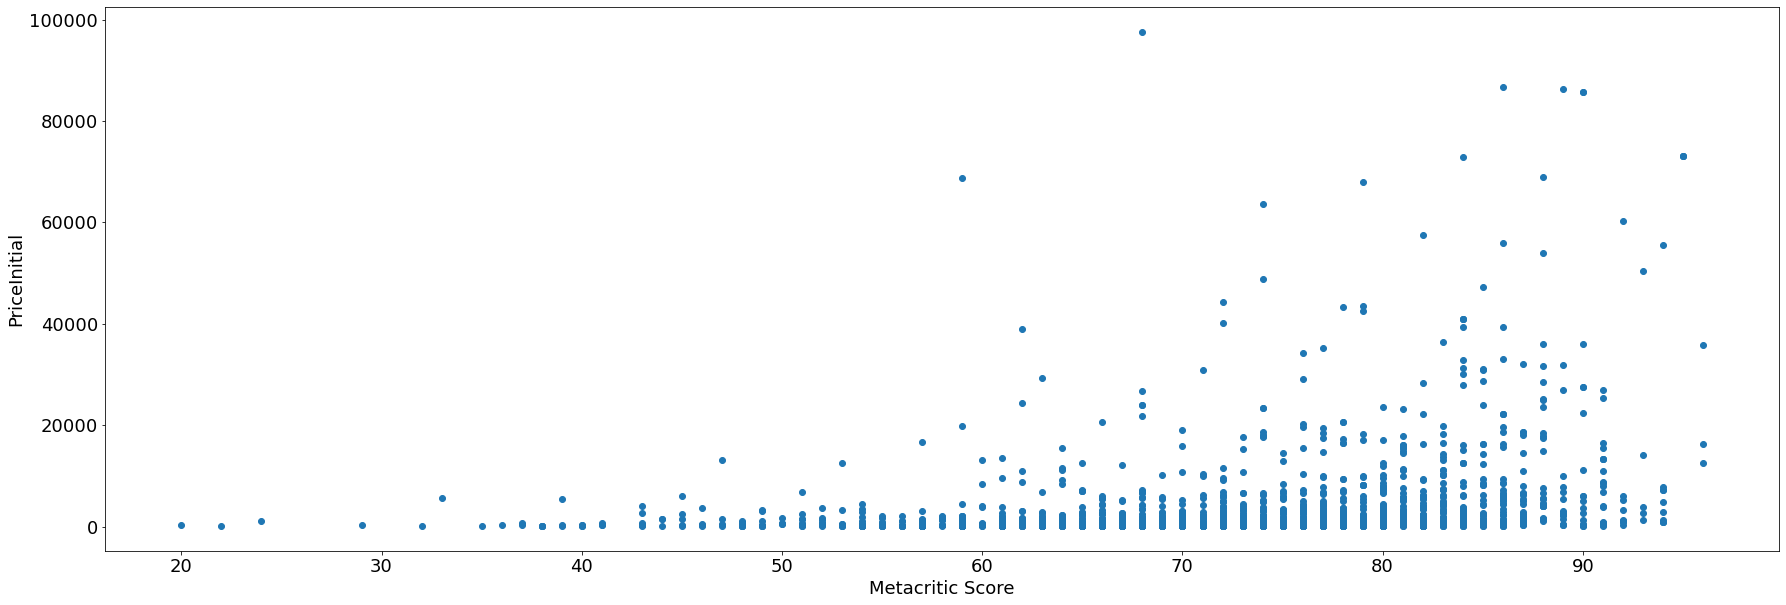

In [95]:
# extract the metacritic score, recommendation count, and name of the game
steam_df = steam_df[['Metacritic', 'RecommendationCount', 'GenreIsNonGame']]
# drop rows with missing values
steam_df = steam_df.dropna()
# drop rows with 0 recommendation count
steam_df = steam_df[steam_df['RecommendationCount'] != 0]
# drop rows with 0 metacritic score
steam_df = steam_df[steam_df['Metacritic'] != 0]

steam_df = steam_df[steam_df['GenreIsNonGame'] == False]


#remove outliers from recommendation count
steam_df = steam_df[steam_df['RecommendationCount'] < 100000]
# steam_df = steam_df[steam_df['PriceInitial'] < 80]
print(len(steam_df))

plt.scatter(steam_df['Metacritic'], steam_df['RecommendationCount'])
plt.xlabel('Metacritic Score')
plt.ylabel('PriceInitial')
# plt.xticks(fontsize=18)
# plt.yticks(fontsize=18)
plt.show()


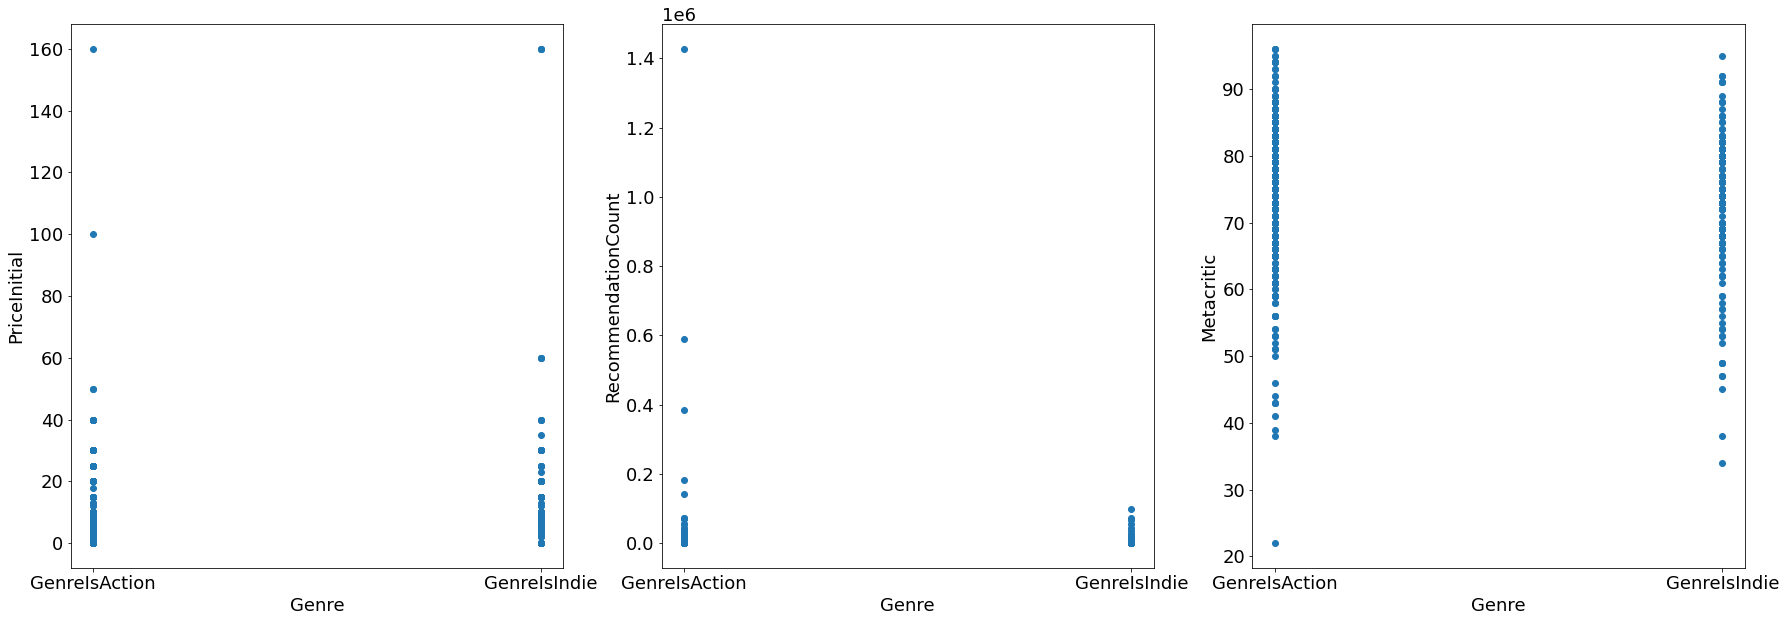

0.7009803921568627
0.6666666666666666


In [90]:
#make a new dataframe with only the ResponseName, ReleaseDate, Metacritic, RecommendationCount, IsFree, and PriceInitial
newDF = steam_df[['ResponseName', 'ReleaseDate', 'Metacritic', 'RecommendationCount', 'IsFree', 'PriceInitial']]


# newDF = steam_df[["ResponseName","ReleaseDate","Metacritic","RecommendationCount","IsFree", "PriceInitial"]]
#add a column for the genre
#how to add a column to a dataframe

genres = ["GenreIsIndie","GenreIsAction","GenreIsAdventure","GenreIsCasual","GenreIsStrategy","GenreIsRPG","GenreIsSimulation","GenreIsEarlyAccess","GenreIsFreeToPlay","GenreIsSports","GenreIsRacing","GenreIsMassivelyMultiplayer"]
temp = []

rows_genres = []

for index, row in steam_df.iterrows():
	# print(row)
	for genre in genres:
		if row[genre] == 1:
			temp.append(genre)
	if len(temp)==1:
		rows_genres.append(temp[0])
		
	# rows_genres.append(tuple(temp))
	temp = []
# np.array(rows_genres, dtype=object)
#create a new dataframe with the genres

#add the genre column to the new dataframe

# newDF['Genre'] = rows_genres
#create a dataframe out of the rows_genres list

# print(rows_genres)
# rows_genres.reshape(-1,1)

genresDF = pd.DataFrame(rows_genres, columns = ['Genre'], dtype=str)
genresDF = genresDF[(genresDF['Genre']=='GenreIsAction') | (genresDF['Genre']=='GenreIsIndie')]
# print(genresDF)
#drop rows with less than 2 genres
# genresDF = genresDF[(genresDF['Genre'].map(len) == 1)]

# for i in range(1, len(genresDF['Genre'])):
# 	#print(genre)
# 	#convert from a tuple to a string
# 	genresDF['Genre'][i-1] = str(genresDF['Genre'][i-1])

# 	print(genresDF['Genre'][i-1])
# 	#print(genre)
#remove rows whose only genre is non-game
# genresDF = genresDF[genresDF['Genre'] != 'GenreIsNonGame']                  

# print(genresDF)
newDF = pd.concat([newDF, genresDF], axis=1)
# newDF = newDF.rename(columns={0: "Genre"})
# print(newDF.columns)

# print(newDF.columns)

sorted_df = newDF.sort_values(by=['Genre', 'ResponseName'], ascending=[True, True])

sorted_df.dropna(inplace=True, subset=['Genre'])
sorted_df = sorted_df[sorted_df['Metacritic'] != 0]

i = 1

with open('genres.txt', 'w') as f:
	for item in sorted_df["Genre"]:
		name = sorted_df["ResponseName"].iloc[i - 1]
		f.write("%7s %50s %25s \n" % (i, name, item))
		i += 1

# plt.rcParams.update({'font.size': 18})

#plot the genres and their recommendation counts
fig, ax = plt.subplots(1,3)
ax[0].scatter(sorted_df['Genre'], sorted_df['PriceInitial'])
ax[0].set_xlabel('Genre')
ax[0].set_ylabel('PriceInitial')
# ax[0].set_xticklabels(sorted_df['Genre'], fontsize=18)
#set the y ticks to be from 0 to 160 with increments of 2
# ax[0].set_yticklabels(range(0, 160, 20), fontsize=18)
ax[1].scatter(sorted_df['Genre'], sorted_df['RecommendationCount'])
ax[1].set_xlabel('Genre')
ax[1].set_ylabel('RecommendationCount')
ax[2].scatter(sorted_df['Genre'], sorted_df['Metacritic'])
ax[2].set_xlabel('Genre')
ax[2].set_ylabel('Metacritic')
plt.show()

#split the data into training and testing sets
X = sorted_df[['Metacritic', 'RecommendationCount', 'PriceInitial']]
y = sorted_df['Genre']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#use a decision tree classifier
from sklearn import tree

# for i in range(1, 10):
# 	clf = tree.DecisionTreeClassifier(max_depth=i)
# 	clf = clf.fit(X_train, y_train)
# 	y_pred = clf.predict(X_test)
# 	print("Accuracy for max depth of " + str(i) + ": " + str(accuracy_score(y_test, y_pred)))

# dtc = tree.DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=10)
# dtc.fit(X_train, y_train)
# # plt.figure(dpi=1000)
# # tree.plot_tree(dtc)
# #show the decision tree

# y_pred = dtc.predict(X_test)
# print(accuracy_score(y_test, y_pred))


#use a random forest classifier
from sklearn.ensemble import RandomForestClassifier

#how to apply K-fold cross validation


# kfold = KFold(n_splits=10, random_state=42, shuffle=True)
# for i in range(1, 10):
# 	rfc = RandomForestClassifier(n_estimators=i, random_state=42)
# 	scores = cross_val_score(rfc, X_train, y_train, cv=kfold)
# 	print("Accuracy for " + str(i) + " estimators: " + str(scores.mean()))


# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import KFold
# kfold = KFold(n_splits=10, random_state=42, shuffle=True)
# for i in range(1, 20):
# 	for j in range(1, 10):
# 		rfc = RandomForestClassifier(n_estimators=i, random_state=42, max_depth=j)
# 		scores = cross_val_score(rfc, X_train, y_train, cv=kfold)
# 		print("Accuracy for " + str(i) + " estimators and " + str(j) + " max depth: " + str(scores.mean()))

rfc = RandomForestClassifier(n_estimators=10, random_state=42, max_depth=4)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_train)
print(accuracy_score(y_train, y_pred))

y_pred = rfc.predict(X_test)
print(accuracy_score(y_test, y_pred))

# rfc = RandomForestClassifier(n_estimators=3, random_state=42, max_depth=3)
# rfc.fit(X_train, y_train)
# y_pred = rfc.predict(X_test)
# print(accuracy_score(y_test, y_pred))


